# File Reference (low level)
This notebook serves as a reference for the different file format in the HeiPorSPECTRAL dataset. This is a low-level description and it is usually not required to load the files directly since the htc framework takes care of that. However, in case you cannot install the htc framework, you can copy the code for the respective functions directly without using the complete framework. The functions listed here are self-contained with no further dependencies than listed in the file itself.

In [1]:
%load_ext autoreload
%autoreload 2

import json

import numpy as np
import pandas as pd
import torch
from PIL import Image

# You can copy the script files directly to use them without installing the htc framework (not recommended, but possible)
from htc import decompress_file, read_meta_file, read_tivita_hsi, settings

In [2]:
example_image_name = "P086#2021_04_15_09_22_02"
example_img = settings.data_dirs["HeiPorSPECTRAL"] / "subjects" / example_image_name.replace("#", "/")

## Data cubes (`data/**/*Spec_Cube.dat` files)
&#127752; htc framework: [`path.read_cube()`](../htc/tivita/DataPath.py)

This file comes from the Tivita camera and stores the spectral data. The HSI cube has a file size of 122.880.012 bytes. The first 12 bytes encode the shape (640, 480, 100) = (width, height, channels) as three int32 values (in big-endian notation). The remaining bytes encode the reflactance values for all 307.200 pixels of the image as float32 numbers (in big-endian notation).
> Please note that the raw spectral data (counts of the camera) are not available since the Tivita system always applies white and dark correction.

You can read the HSI cube with the `read_tivita_hsi()` function. The first two axes are transposed so that first the rows and then the columns of the image are encoded (height, width, channels).

In [3]:
cube = read_tivita_hsi(example_img / "2021_04_15_09_22_02_SpecCube.dat")
print(f"(height, width, channels) = {cube.shape}")
print(f"{cube.dtype = }")

(height, width, channels) = (480, 640, 100)
cube.dtype = dtype('float32')


In [4]:
# Access a single spectra
row = 10
col = 20
cube[row, col]

array([0.27184397, 0.18266782, 0.16965799, 0.1513006 , 0.1329092 ,
       0.15426329, 0.14148699, 0.0999187 , 0.090902  , 0.12238958,
       0.09820482, 0.08726134, 0.08246506, 0.08394987, 0.07913913,
       0.08583497, 0.07791902, 0.07350975, 0.06822228, 0.05753687,
       0.05778656, 0.05996892, 0.06155088, 0.06053223, 0.06277863,
       0.06049408, 0.06231851, 0.06106466, 0.06252275, 0.06397039,
       0.06673231, 0.07459199, 0.07646118, 0.08570325, 0.10915031,
       0.11551961, 0.13204259, 0.1518341 , 0.18475193, 0.21778633,
       0.26116806, 0.28271756, 0.3110851 , 0.36204976, 0.40289694,
       0.4554861 , 0.50583446, 0.56842065, 0.5907381 , 0.6675972 ,
       0.71503276, 0.7530693 , 0.82546747, 0.8446979 , 0.91822845,
       0.9467858 , 0.99090135, 1.0418077 , 1.0990275 , 1.1299974 ,
       1.1064113 , 1.1354612 , 1.1758112 , 1.1448709 , 1.2238101 ,
       1.1803787 , 1.2609162 , 1.2796235 , 1.2335976 , 1.2471465 ,
       1.2612877 , 1.289348  , 1.3076123 , 1.298694  , 1.29760

## Camera metadata (`data/**/*meta.log` files)
&#127752; htc framework: [`path.read_camera_meta()`](../htc/tivita/DataPath.py)

This file comes from the Tivita camera and contains meta information about the image like the software version or the camera identifier. It uses an INI file format which you can read with the following function. It returns a dictionary and the group identifiers (like `Camera`) are prepended to the attributes:

In [5]:
read_meta_file(example_img / "2021_04_15_09_22_02_meta.log")

{'Camera_CamID': '0202-00118',
 'Camera_Exposure': 75,
 'Camera_analoger Gain': 4,
 'Camera_digitaler Gain': 32,
 'Camera_Speed': 950,
 'SW_Name': 'TIVITA® Suite',
 'SW_Version': '1.6.0.1',
 'Fremdlichterkennung_Fremdlicht erkannt?': False,
 'Fremdlichterkennung_PixelmitFremdlicht': 0,
 'Fremdlichterkennung_Breite LED Rot': 50,
 'Fremdlichterkennung_Breite LED Gruen': 50,
 'Fremdlichterkennung_Grenzwert Pixelanzahl': 100,
 'Fremdlichterkennung_Intensity Grenzwert': 7.0,
 'Aufnahme_Aufnahmemodus': 'Reflektanz'}

## Annotation metadata (`data/**/annotations/*_meta.json` files)
&#127752; htc framework: [`path.read_annotation_meta()`](../htc/tivita/DataPath.py)

This is a custom file where you can find additional information about the annotation or the image aquisition. Here, the `situs`, `angle`, `repetition` configuration for the annotated labels is stored. It is a JSON file which you can directly read in Python.

In [6]:
with (example_img / "annotations/2021_04_15_09_22_02_meta.json").open() as f:
    annotation_meta = json.load(f)
annotation_meta

{'label_meta': {'spleen': {'situs': 1, 'angle': 0, 'repetition': 1}}}

## Annotations (`data/**/annotations/*binary.png` and `data/**/annotations/*coordinates.csv` files)
&#127752; htc framework: [`path.read_segmentation()`](../tivita/DataPath.py)

These files store the annotated polygon region in the image as binary mask and as a list of coordinates. The naming convention of the files is `timestamp#annotation_name#label_name#file_type`, e.g. `2021_04_15_09_22_02#polygon#annotator1#spleen#binary.png` (`polygon#annotator1` is the annotation_name). The binary mask contains white pixels for the annotated polygon and black pixels for the remaining pixels (only the values 0 and 1 exist). The coordinates is a CSV table denoting the corners of the polygon (in the order it was drawn). The first column denotes the x-position (image column) and the second column the y-position (image row).
> &#x26a0;&#xfe0f; It is not recommended to convert the coordinates back to the polygon as there can be subtle differences (e.g. due to different anti-alising settings). Please use the binary mask directly.

> &#x26a0;&#xfe0f; It is actually also not recommended to read the binary mask directly. If you want the polygon annotations, please have a look at how to read the segmentation annotations below. This gives you the polygons in a convenient array format and also includes always polygons from all labels.

(480, 640) bool


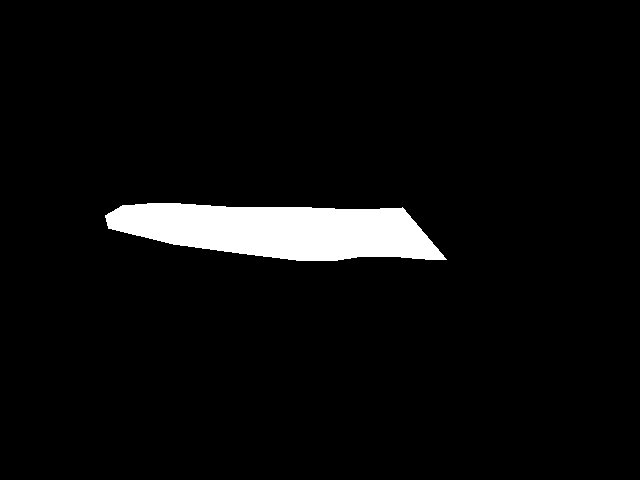

In [7]:
img = Image.open(example_img / "annotations/2021_04_15_09_22_02#polygon#annotator1#spleen#binary.png")
print(np.array(img).shape, np.array(img).dtype)
img

In [8]:
pd.read_csv(
    example_img / "annotations/2021_04_15_09_22_02#polygon#annotator1#spleen#coordinates.csv", names=["col", "row"]
)

,col,row
0,403.0,208.0
1,358.0,210.0
2,312.0,208.0
3,241.0,208.0
4,181.0,204.0
5,148.0,204.0
6,123.0,206.0
7,106.0,216.0
8,109.0,229.0
9,174.0,245.0


## Preprocessed L1 images (`intermediates/preprocessing/L1/*` files)
&#127752; htc framework: [`DatasetImage`](../htc/models/image/DatasetImage.py)

Here are all L1 normalized HSI images stored as [blosc](https://www.blosc.org/) compressed numpy array.

In [9]:
data = decompress_file(settings.intermediates_dir_all / "preprocessing/L1" / f"{example_image_name}.blosc")
(data.shape, data.dtype)

((480, 640, 100), dtype('float16'))

In [10]:
np.sum(data[0, 0, :])

1.0

The spectra are stored in the float16 format for effeciency reasons: smaller size and faster to load. This is especially important when training on a GPU to ensure an efficient data loading. From our experience, float16 has enough precision for most spectra but it could still be advisable to convert the data to float32 before critical computations (see the [`PrecisionAnalysis`](../htc/data_exploration/PrecisionAnalysis.ipynb) notebook for further information). However, this should be only done *after* the data moved to the GPU to reduce memory transfer costs.

In [11]:
t = torch.from_numpy(data)
# First move to the GPU
t = t.cuda()
# Then convert to float
t = t.float()
(t.shape, t.dtype)

(torch.Size([480, 640, 100]), torch.float32)

## Preprocessed parameter images (`intermediates/preprocessing/parameter_images/*` files)
&#127752; htc framework: [`DatasetImage`](../models/image/DatasetImage.py) or [`path.compute_sto2()`](../tivita/DataPath.py), [`path.compute_nir()`](../tivita/DataPath.py), etc.

Here are all the precomputed parameter images (e.g. TWI) stored as dict of [blosc](https://www.blosc.org/) compressed numpy arrays.

In [12]:
decompress_file(settings.intermediates_dir_all / "preprocessing/parameter_images" / f"{example_image_name}.blosc")

{'StO2': array([[0.02002788, 0.01709557, 0.01709557, ..., 0.33653784, 0.33653784,
         0.4033152 ],
        [0.04322731, 0.01918328, 0.01918328, ..., 0.3284588 , 0.2712109 ,
         0.35009134],
        [0.04322731, 0.01918328, 0.01709557, ..., 0.2519877 , 0.22937965,
         0.22407174],
        ...,
        [0.51141024, 0.51141024, 0.5116955 , ..., 0.6849694 , 0.6849694 ,
         0.7202072 ],
        [0.4780488 , 0.50316405, 0.5116955 , ..., 0.6849694 , 0.6849694 ,
         0.6849694 ],
        [0.4780488 , 0.4780488 , 0.53568697, ..., 0.66323185, 0.66323185,
         0.6849694 ]], dtype=float32),
 'NIR': array([[1.0000000e-06, 1.0000000e-06, 1.0000000e-06, ..., 3.3124089e-01,
         3.6931872e-01, 2.4699521e-01],
        [1.0000000e-06, 1.0000000e-06, 1.0000000e-06, ..., 3.3233237e-01,
         2.8239799e-01, 2.6467824e-01],
        [1.0000000e-06, 1.0000000e-06, 1.0000000e-06, ..., 2.3999858e-01,
         2.6326299e-01, 3.2801270e-01],
        ...,
        [3.9863324e-01, 

The Tivita camera usually runs a background predictions and automatically blacks out those areas in the parameter images. In contrast, the values above are the original values without any background predictions. Instead, the result of the background prediction is stored extra in the `background` key with `True` indicating a background (i.e. invalid) pixel.

## Segmentation annotations (`intermediates/segmentations/*` files)
&#127752; htc framework: [`path.read_segmentation()`](../htc/tivita/DataPath.py)

These files store the combined polygon annotations for each image as [blosc](https://www.blosc.org/) compressed numpy arrays. In contrast to the binary PNG files from above, you read directly a label image with label indices according to the label mapping defined in the `dataset_settings.json`. Further, the label image contains polygons for all organs at once. That is, if an image has two polygon annotations, they are both included in the label mask. The loaded data is a dictionary with a label mask per `annotation_name`.

In [13]:
seg = decompress_file(settings.intermediates_dir_all / "segmentations" / f"{example_image_name}.blosc")
seg

{'polygon#annotator1': array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 'polygon#annotator2': array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 'polygon#annotator3': array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)}

In [14]:
np.unique(seg["polygon#annotator1"])

array([  7, 255], dtype=uint8)

The label mapping of the dataset settings tell you the meaning of the label indices (e.g. 7 corresponds to the spleen annotation).

&#127752; htc framework: [`DatasetSettings`](../htc/tivita/DatasetSettings.py)

In [15]:
with (settings.data_dirs["HeiPorSPECTRAL"] / "dataset_settings.json").open() as f:
    seg_meta = json.load(f)
seg_meta

{'dataset_name': 'HeiPorSPECTRAL',
 'data_path_class': 'htc.tivita.DataPathMultiorgan>DataPathMultiorgan',
 'shape': [480, 640, 100],
 'shape_names': ['height', 'width', 'channels'],
 'label_mapping': {'stomach': 0,
  'small_bowel': 1,
  'colon': 2,
  'liver': 3,
  'gallbladder': 4,
  'pancreas': 5,
  'kidney': 6,
  'spleen': 7,
  'bladder': 8,
  'omentum': 9,
  'lung': 10,
  'heart': 11,
  'cartilage': 12,
  'bone': 13,
  'skin': 14,
  'muscle': 15,
  'peritoneum': 16,
  'major_vein': 17,
  'kidney_with_Gerotas_fascia': 18,
  'bile_fluid': 19,
  'overlap': 254,
  'unlabeled': 255},
 'last_valid_label_index': 19,
 'label_ordering': {'stomach': '01',
  'small_bowel': '02',
  'colon': '03',
  'liver': '04',
  'gallbladder': '05',
  'pancreas': '06',
  'kidney': '07',
  'spleen': '08',
  'bladder': '09',
  'omentum': '10',
  'lung': '11',
  'heart': '12',
  'cartilage': '13',
  'bone': '14',
  'skin': '15',
  'muscle': '16',
  'peritoneum': '17',
  'major_vein': '18',
  'kidney_with_Gerot

## Median spectra table (`intermediates/tables/HeiPorSPECTRAL@median_spectra@*` files)
&#127752; htc framework: [`median_table()`](../htc/utils/helper_functions.py)

It is very often convenient to work with median spectra instead of the raw spectra as the latter can be quite noisy. This is why computed the median spectra per image, label and annotator and stored them in tables in the precomputed files. The files are split per `annotation_name` and are stored as CSV and feather file. The CSV file can be useful for visualization to open in your favorite spreadsheet editor. However, for optimal performance it is highly recommended to use the feather files (smaller and faster to read).

In [16]:
df = pd.read_feather(settings.intermediates_dir_all / "tables/HeiPorSPECTRAL@median_spectra@polygon#annotator1.feather")
df

,image_name,subject_name,timestamp,label_index,label_name,median_spectrum,std_spectrum,median_normalized_spectrum,std_normalized_spectrum,n_pixels,...,SW_Name,SW_Version,Fremdlichterkennung_Fremdlicht erkannt?,Fremdlichterkennung_PixelmitFremdlicht,Fremdlichterkennung_Breite LED Rot,Fremdlichterkennung_Breite LED Gruen,Fremdlichterkennung_Grenzwert Pixelanzahl,Fremdlichterkennung_Intensity Grenzwert,Aufnahme_Aufnahmemodus,camera_name
0,P086#2021_04_15_11_38_04,P086,2021_04_15_11_38_04,0,stomach,"[0.298144, 0.2833822, 0.2614737, 0.23648293, 0...","[0.17259361, 0.16893886, 0.16671665, 0.1658238...","[0.0063450593, 0.006019631, 0.005552271, 0.005...","[0.001271573, 0.0011821607, 0.0011256082, 0.00...",34203,...,TIVITA® Suite,1.6.0.1,False,6.0,50.0,50.0,100.0,7.0,Reflektanz,0202-00118_correct-1
1,P086#2021_04_15_11_38_26,P086,2021_04_15_11_38_26,0,stomach,"[0.2836912, 0.26937896, 0.2474714, 0.2232979, ...","[0.15054636, 0.14754522, 0.14422333, 0.1433670...","[0.0063025337, 0.005978748, 0.0055006156, 0.00...","[0.0011646454, 0.0010641138, 0.0010057053, 0.0...",40668,...,TIVITA® Suite,1.6.0.1,False,0.0,50.0,50.0,100.0,7.0,Reflektanz,0202-00118_correct-1
2,P086#2021_04_15_11_38_46,P086,2021_04_15_11_38_46,0,stomach,"[0.31284106, 0.29669726, 0.27237016, 0.2458267...","[0.22051434, 0.2156419, 0.21059874, 0.20798233...","[0.006193708, 0.005865203, 0.00539036, 0.00485...","[0.0013146227, 0.0012250107, 0.0011614197, 0.0...",40530,...,TIVITA® Suite,1.6.0.1,False,0.0,50.0,50.0,100.0,7.0,Reflektanz,0202-00118_correct-1
3,P086#2021_04_15_11_39_47,P086,2021_04_15_11_39_47,0,stomach,"[0.21817692, 0.20727506, 0.19052061, 0.1700369...","[0.11722602, 0.11280198, 0.10882231, 0.1058688...","[0.005955641, 0.0056763296, 0.005219719, 0.004...","[0.0010781332, 0.0009825683, 0.000938003, 0.00...",32755,...,TIVITA® Suite,1.6.0.1,False,0.0,50.0,50.0,100.0,7.0,Reflektanz,0202-00118_correct-1
4,P086#2021_04_15_11_40_03,P086,2021_04_15_11_40_03,0,stomach,"[0.22648579, 0.21569103, 0.19833657, 0.1769348...","[0.16263519, 0.1591804, 0.15491623, 0.15301572...","[0.005900712, 0.0056145145, 0.0051732482, 0.00...","[0.0011768824, 0.0010873155, 0.0010396767, 0.0...",29989,...,TIVITA® Suite,1.6.0.1,False,0.0,50.0,50.0,100.0,7.0,Reflektanz,0202-00118_correct-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5753,P096#2021_05_06_15_28_36,P096,2021_05_06_15_28_36,19,bile_fluid,"[0.2697025, 0.2929984, 0.31844398, 0.35280922,...","[0.023736877, 0.023094563, 0.022490172, 0.0239...","[0.003944449, 0.0042777774, 0.00469031, 0.0051...","[0.00027948705, 0.00023092398, 0.00021718781, ...",212,...,TIVITA® Suite,1.6.0.1,False,0.0,50.0,50.0,100.0,7.0,Reflektanz,0202-00118_correct-1
5754,P096#2021_05_06_15_28_54,P096,2021_05_06_15_28_54,19,bile_fluid,"[0.2716373, 0.29821837, 0.32699224, 0.35788986...","[0.022481319, 0.02279567, 0.023404775, 0.02491...","[0.0040078103, 0.004326169, 0.0047555175, 0.00...","[0.00026184923, 0.00023373059, 0.00022477358, ...",217,...,TIVITA® Suite,1.6.0.1,False,0.0,50.0,50.0,100.0,7.0,Reflektanz,0202-00118_correct-1
5755,P096#2021_05_06_15_29_23,P096,2021_05_06_15_29_23,19,bile_fluid,"[0.29648936, 0.32319617, 0.35186213, 0.3834723...","[0.031547118, 0.030895296, 0.031834405, 0.0334...","[0.0043794527, 0.0047872895, 0.0052062217, 0.0...","[0.00040560725, 0.0003736044, 0.00035140596, 0...",1078,...,TIVITA® Suite,1.6.0.1,False,0.0,50.0,50.0,100.0,7.0,Reflektanz,0202-00118_correct-1
5756,P096#2021_05_06_15_29_42,P096,2021_05_06_15_29_42,19,bile_fluid,"[0.30476114, 0.33271345, 0.3607675, 0.39154196...","[0.030348146, 0.03109946, 0.031819478, 0.03337...","[0.004464597, 0.0048542684, 0.0053060246, 0.00...","[0.0003804933, 0.00036229528, 0.00034811712, 0...",1093,...,TIVITA® Suite,1.6.0.1,False,0.0,50.0,50.0,100.0,7.0,Reflektanz,0202-00118_correct-1


The median spectra are stored together with the standard deviation (across pixels) based on the original reflectance values (`median_spectrum` and `std_spectrum`) and L1 normalized values (`median_normalized_spectrum` and `std_normalized_spectrum`). The median or standard deviation are always computed  separately per channel. With this, you can e.g. compute the mean median for one label and subject:

In [17]:
np.mean(np.stack(df.query("subject_name == 'P086' and label_name == 'stomach'")["median_normalized_spectrum"]), axis=0)

array([0.00569556, 0.00539343, 0.00493511, 0.00439442, 0.00388978,
       0.00341763, 0.00305485, 0.00289374, 0.00286906, 0.00297261,
       0.00320141, 0.00337222, 0.00334488, 0.00311466, 0.00275871,
       0.00260884, 0.00296069, 0.00398086, 0.00544276, 0.00691271,
       0.00820837, 0.00925623, 0.01005311, 0.01066358, 0.01114419,
       0.01149988, 0.01169644, 0.01184943, 0.01204176, 0.01217559,
       0.01219215, 0.01219339, 0.01225503, 0.01237501, 0.0125388 ,
       0.01269636, 0.01288586, 0.0130301 , 0.01314327, 0.01325227,
       0.01331921, 0.01337158, 0.01336941, 0.01335011, 0.01331912,
       0.01327379, 0.01316272, 0.01300617, 0.01280926, 0.01263029,
       0.0124914 , 0.0124149 , 0.01241297, 0.01246099, 0.01251573,
       0.01258401, 0.01263085, 0.01265569, 0.01266809, 0.012667  ,
       0.01265957, 0.01262518, 0.01256868, 0.0125306 , 0.01245986,
       0.01230729, 0.01216823, 0.01205354, 0.01195057, 0.01184324,
       0.01175236, 0.0116702 , 0.01157559, 0.01148722, 0.01140

> &#x26a0;&#xfe0f; With these kind of operations it is important to respect the hierarchy of the data, i.e. do not simply aggregate all median spectra from all subjects at once. Instead, first aggregate for one subject and then across subjects. In the htc framework, we have the [`group_median_spectra()`](../htc/utils/helper_functions.py) function for this.

> Note: There is also a `HeiPorSPECTRAL@meta` table in this folder. It contains similar information as the median spectra table but without the spectra and one row denotes an image (and not a label from an image). It is mainly used for internal purposes and you probably don't need it.

&#127752; htc framework: [`group_median_spectra()`](../htc/utils/helper_functions.py)

## Spectrometer measurements (`data/extra_technical_validation/spectrometer/2022_09_19_colorchecker/*` files)
&#127752; htc framework: [`SpectrometerReader()`](../htc/utils/SpectrometerReader.py)

These files contain the raw spectrometer measurements of the colorchecker image using the Ocean Insight HR2000+ spectrometer. Each file contains one spectrum with some header information in the beginning ending with a `>>>>>Begin Spectral Data<<<<<` section followed by the raw spectral data. In this section, there are two numbers per row with the wavelength in nm on the left and the reflectance data on the right side. For each color chip (+ white and dark calibrations), there are 100 measurements.

In [18]:
colorchecker_dir = (
    settings.data_dirs["HeiPorSPECTRAL"] / "extra_technical_validation/spectrometer/2022_09_19_colorchecker"
)
len(list(colorchecker_dir.iterdir()))

2600

In [19]:
with (colorchecker_dir / "blue_sky_HRC33631__0__00300.txt").open() as f:
    raw_spectra = f.readlines()

print("".join(raw_spectra[:20]))

Data from blue_sky_HRC33631__0__00300.txt Node

Date: Mon Sep 19 14:20:31 CEST 2022
User: pai
Spectrometer: HR+C3363
Trigger mode: 0
Integration Time (sec): 1.000000E-1
Scans to average: 1
Electric dark correction enabled: true
Nonlinearity correction enabled: false
Boxcar width: 0
XAxis mode: Wavelengths
Number of Pixels in Spectrum: 2048
>>>>>Begin Spectral Data<<<<<
187.255	16.75
187.731	16.75
188.206	16.75
188.682	-7.25
189.158	18.75
189.634	1.75



## Colorchecker annotations (`data/extra_technical_validation/Tivita_0202-00118/**/annotations/*cc_classic.png` files)
&#127752; htc framework: [`path.read_colorchecker_mask()`](../htc/tivita/DataPath.py)

These images contain the automatically generated annotations (cf. [`ColorcheckerMaskCreation.ipynb`](../htc/utils/ColorcheckerMaskCreation.ipynb) notebook) for the colorchecker images. They are very similar to the blosc segmentations in the intermediates of the main dataset storing a label index for each pixel. For the colorchecker images, there are 24 labels (indices 1–24) and the background (index 0). The [`ColorcheckerReader`](../htc/utils/ColorcheckerReader.py) class contains the exact label mapping.

In [20]:
img = Image.open(
    settings.data_dirs["HeiPorSPECTRAL"]
    / "extra_technical_validation/Tivita_0202-00118/2022_12_25_colorchecker/2022_12_25_20_45_29/annotations/2022_12_25_20_45_29#squares#automask#cc_classic.png"
)
np.unique(img, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24], dtype=int32),
 array([208896,   4096,   4096,   4096,   4096,   4096,   4096,   4096,
          4096,   4096,   4096,   4096,   4096,   4096,   4096,   4096,
          4096,   4096,   4096,   4096,   4096,   4096,   4096,   4096,
          4096]))